In [21]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
from fbprophet import Prophet

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'whitegrid' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [3]:
df = pd.read_csv('../my_data/processed/simple_date.csv', index_col=0)
df.head()

,user_id,platform,product,date
0,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-17
1,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-26
2,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-16
3,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-20
4,468660be9c3ccd8f10e4b4778b85b076,Mobile,sport,2016-06-17


In [13]:
# group by source, take the mean of conversion
gb_product = df.groupby(['product']).size().sort_values(ascending=False).to_frame()
gb_product.head()

,0
product,
sport,9873222
news,2651497
homepageandsearch,1868801
tvandiplayer,533226
weather,403823


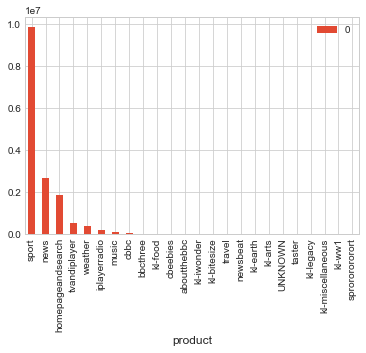

In [14]:
gb_product.plot(kind='bar')

In [16]:
# group by source, take the mean of conversion
gb_platform = df.groupby(['platform']).size().sort_values(ascending=False).to_frame()
gb_platform.head()

,0
platform,
Computer,5433941
Tablet,4415217
Mobile,4229074
Unspecified,1716370
Unknown,48113


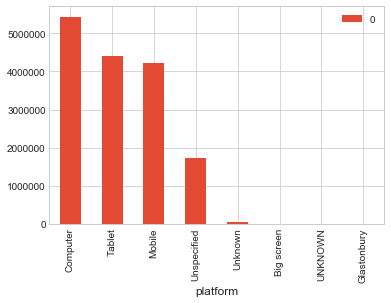

In [17]:
gb_platform.plot(kind='bar')

The first and last day seem to contain incomplete data so won't be much use for training a model. We should drop these. 
2016-06-12
2017-03-01 

In [47]:
df = df.drop(df[df.date == '2016-06-12'].index)
df = df.drop(df[df.date == '2017-03-01'].index)

In [52]:
pro_df = df.groupby(['date']).size()

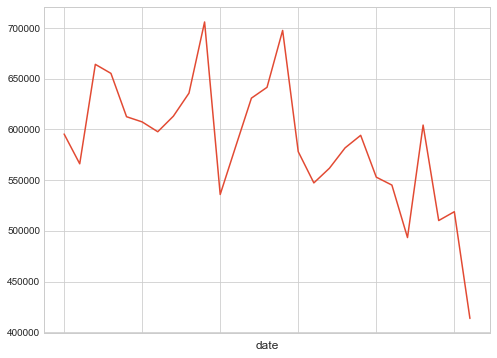

In [53]:
pro_df.plot(kind='line')

## FB Prophet
Next I will use a project by Facebook called FBProphet, A great libarary for forecasting time series data with a particular focus on seasonality. It deals with weekly, monthly and holiday seasonality very well.

In [68]:
pro_df = pro_df.to_frame().reset_index()

In [70]:
pro_df.columns=['ds', 'y']
pro_df.head()

,ds,y
0,2016-06-13,595442
1,2016-06-14,566104
2,2016-06-15,664133
3,2016-06-16,655219
4,2016-06-17,612507


In [77]:
m = Prophet(daily_seasonality=True)
m.fit(pro_df)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


,ds,yhat,yhat_lower,yhat_upper
52,2016-08-04,389946.686419,335757.543848,454482.650142
53,2016-08-05,397726.140433,338295.244478,455458.956153
54,2016-08-06,384831.841995,325562.028569,445999.295199
55,2016-08-07,405566.537169,345267.406550,464133.040015
56,2016-08-08,405273.721409,349086.380208,462354.298186


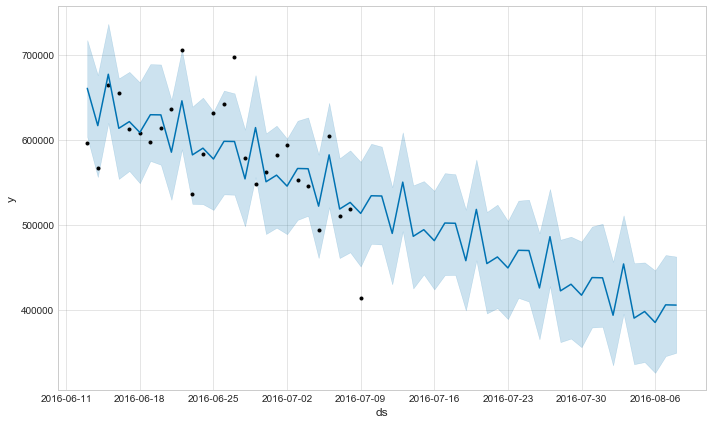

In [81]:
m.plot(forecast);

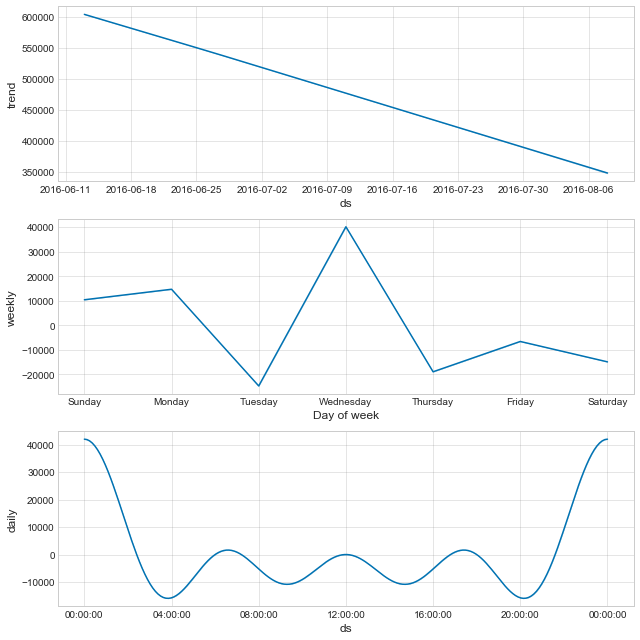

In [82]:
m.plot_components(forecast);

So there is a lot to talk about already.
In terms of a general trend at BBC (just off of these two months data), the trend is that over time we are losing our audience. Our traffic peaks on Wednesday, probably due to some sort of sporting event. We get more traffic on Sunday and Monday as well.
we also get daily traffic spikes at mealtimes and then in the late evening.
This begs a question to me, how do our consumers of different products behave?

In [121]:
def build_prophet(df, product):
    df = df[df['product'] == product]
    
    gb_df = df.groupby(['date']).size()
    gb_df = gb_df.to_frame().reset_index()
    gb_df.columns=['ds', 'y']

    # build Prophet    
    m = Prophet(daily_seasonality=True)
    m.fit(gb_df)

    # Predict 30 days into the future    
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    # plot     
    m.plot(forecast);
    m.plot_components(forecast);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


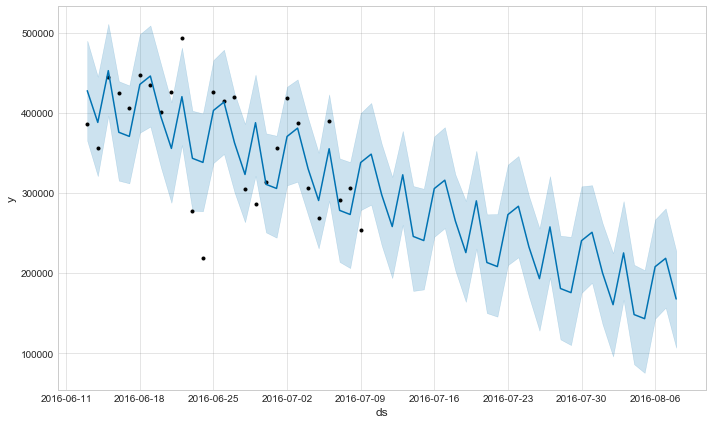

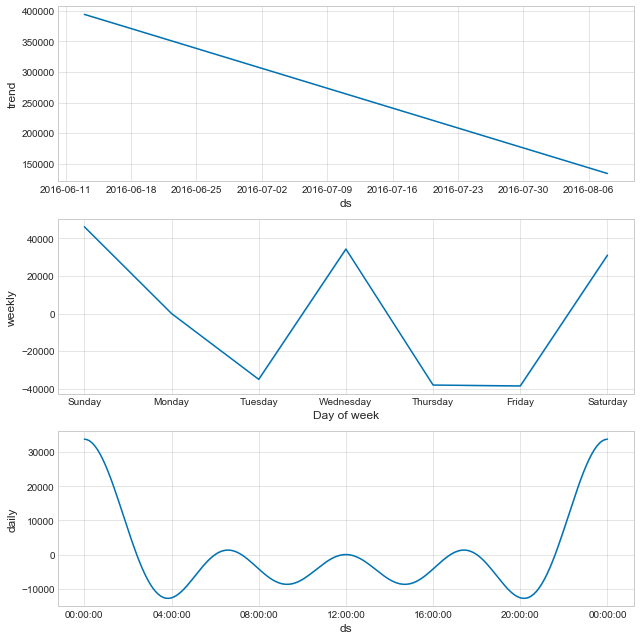

In [122]:
build_prophet(df, 'sport')

For The Sports product we have a similar output to our generic graph. This makes sense as most of our data is the sports product. This means we can try to answer the question as to the unatural Wednesday spike in this period, suggests something happened. Perhaps the UEFA cup?

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


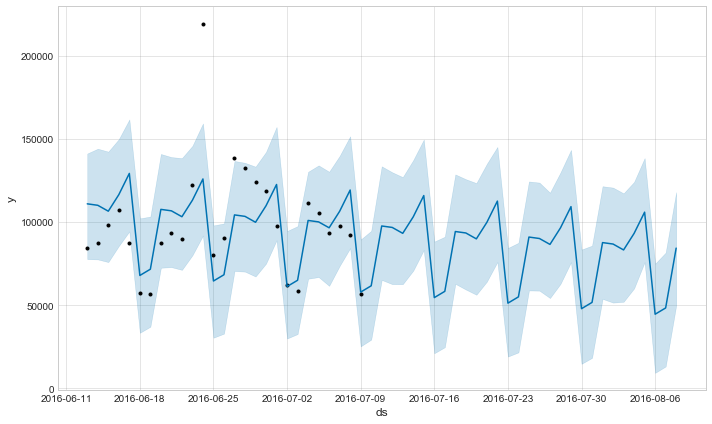

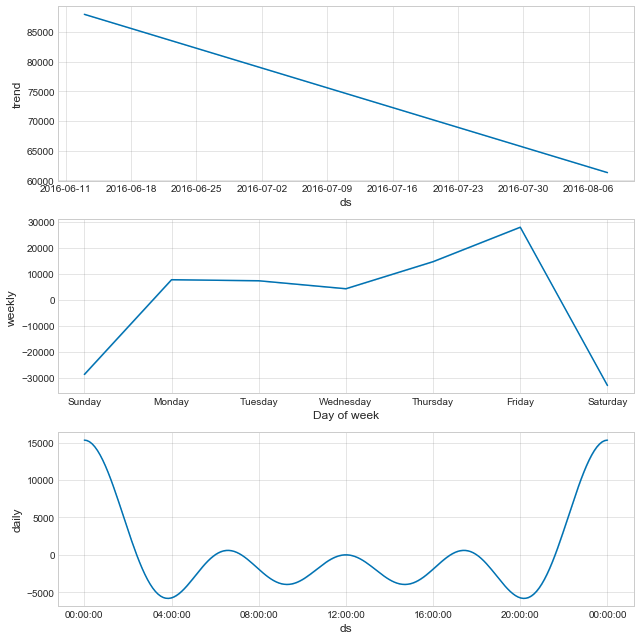

In [123]:
build_prophet(df, 'news')

News is also a declining product, peaking across the weekdays and spiking on Friday, then dropping on Saturdays and Sundays.

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


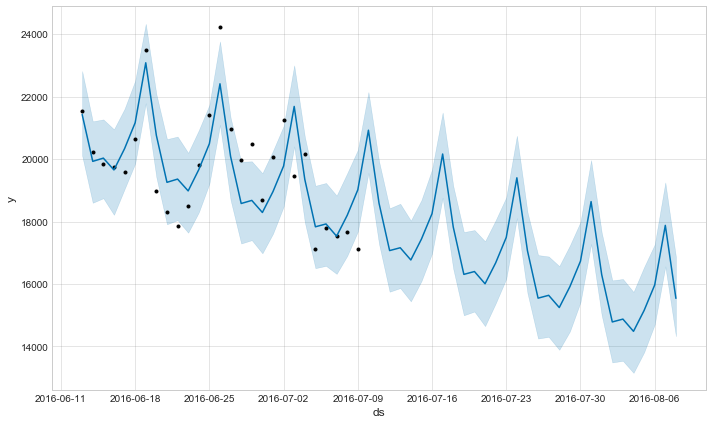

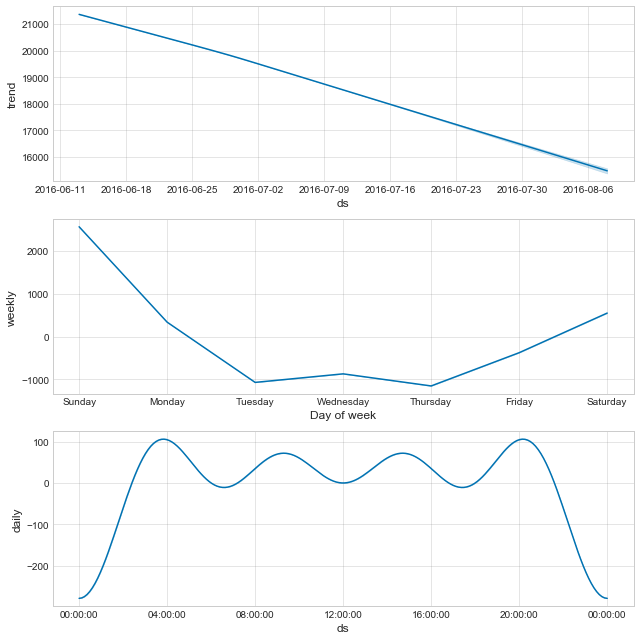

In [124]:
build_prophet(df, 'tvandiplayer')

IPlayer has a very different trend, while it is still declining. Viewing spikes on a Sunday, with increases on Friday,Saturday and Monday.

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


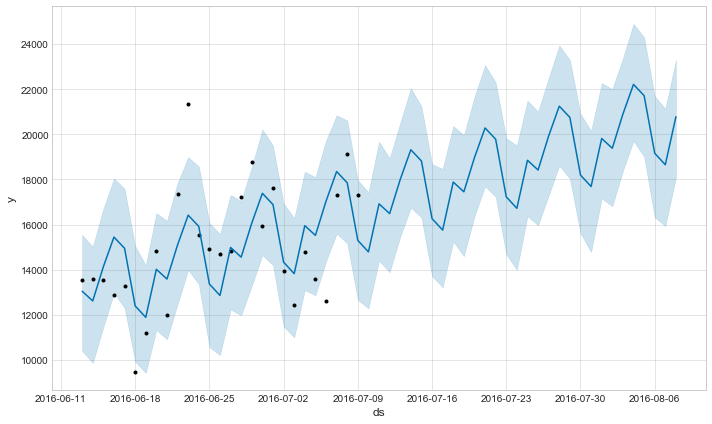

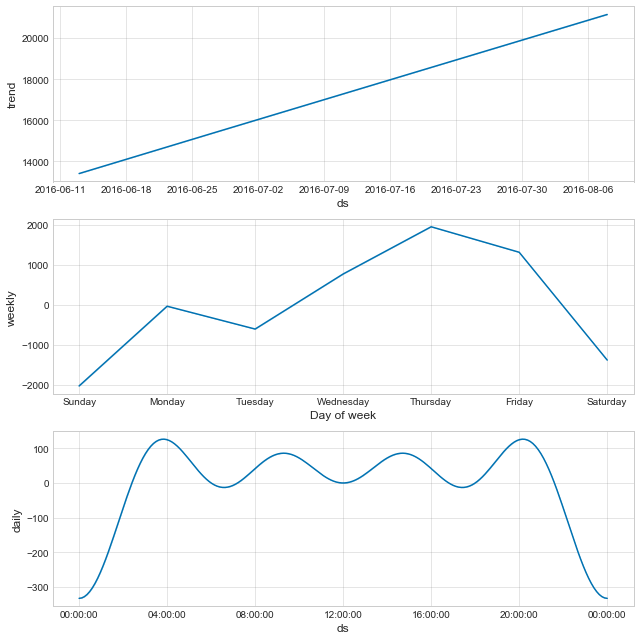

In [125]:
build_prophet(df, 'weather')

Weather is intersting in that it is a growing service! Something about the weather is becoming more popular, this may be seasonal to Summer over a June period and we would need more data to answer more questions. Weather is checked the most on Thursday, perhaps for people preparing for the weekend.

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


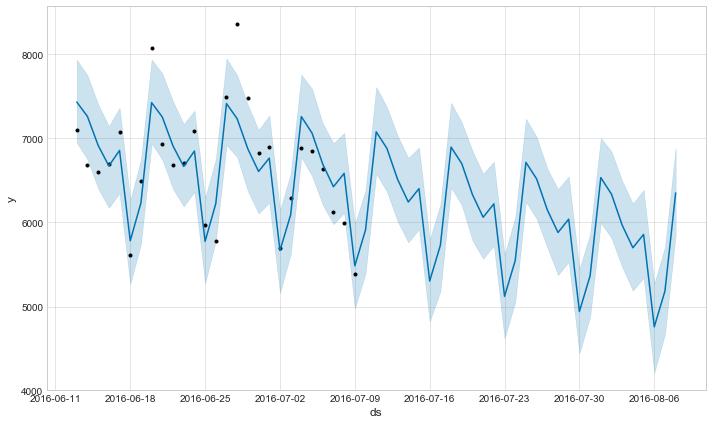

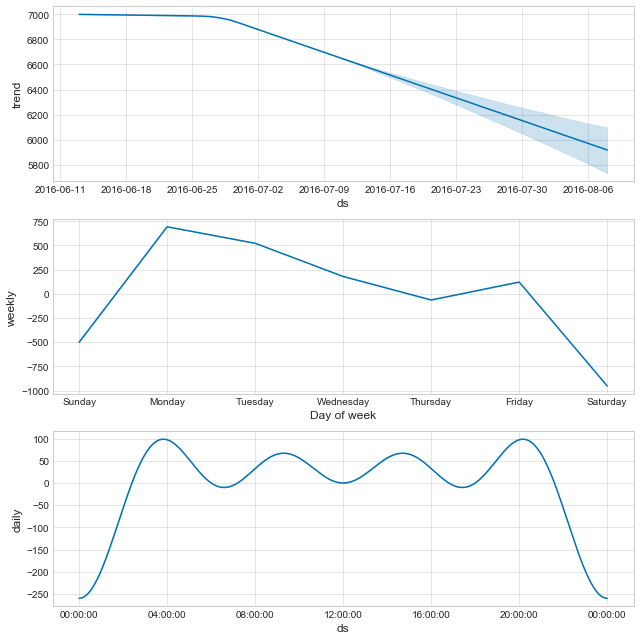

In [126]:
build_prophet(df, 'iplayerradio')

Raido is also slowly declining, spiking midweek perhaps as it is listened to more at work than at home.

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


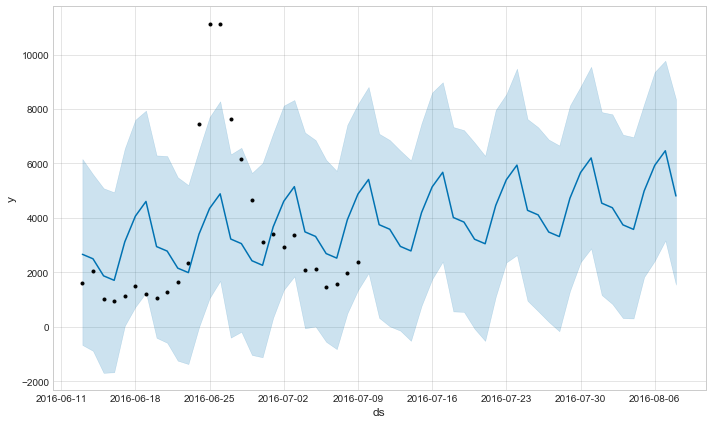

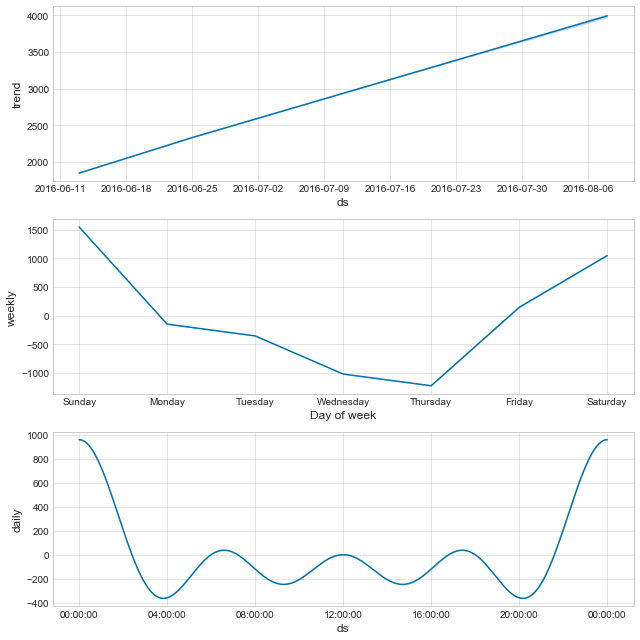

In [127]:
build_prophet(df, 'music')

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


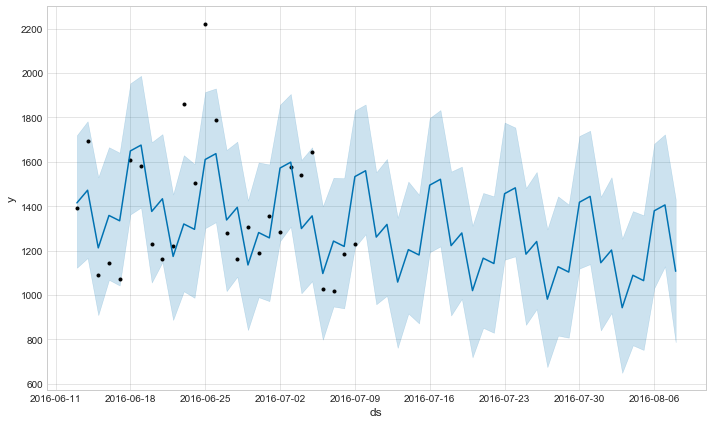

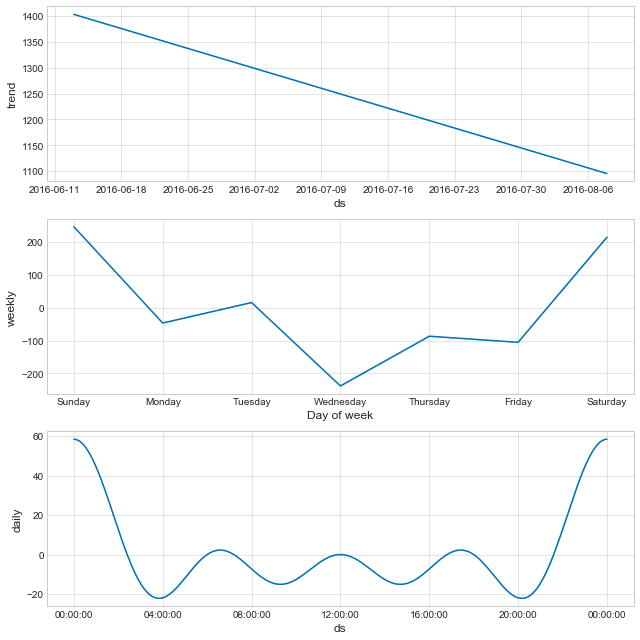

In [128]:
build_prophet(df, 'cbbc')

The Music section has a huge spike at the end of June, this is Glastonbury. Our predictions are not so strongly swayed by this large event in it's predictions.

I am also going to breifly look at the three largest platforms.

In [129]:
def build_platform_prophet(df, platform):
    df = df[df['platform'] == platform]
    
    gb_df = df.groupby(['date']).size()
    gb_df = gb_df.to_frame().reset_index()
    gb_df.columns=['ds', 'y']

    # build Prophet    
    m = Prophet(daily_seasonality=True)
    m.fit(gb_df)

    # Predict 30 days into the future    
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)

    # plot     
    m.plot(forecast);
    m.plot_components(forecast);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


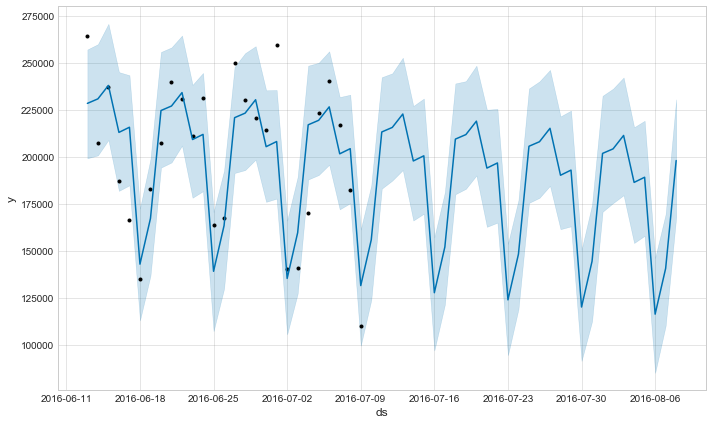

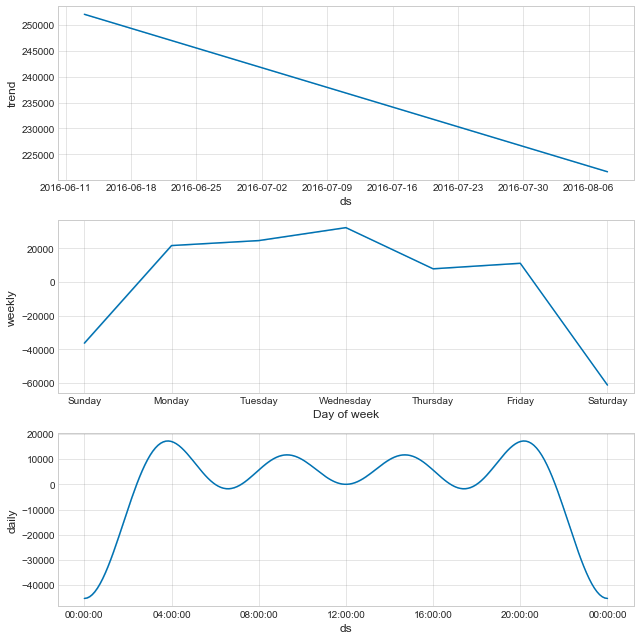

In [130]:
build_platform_prophet(df, 'Computer')

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


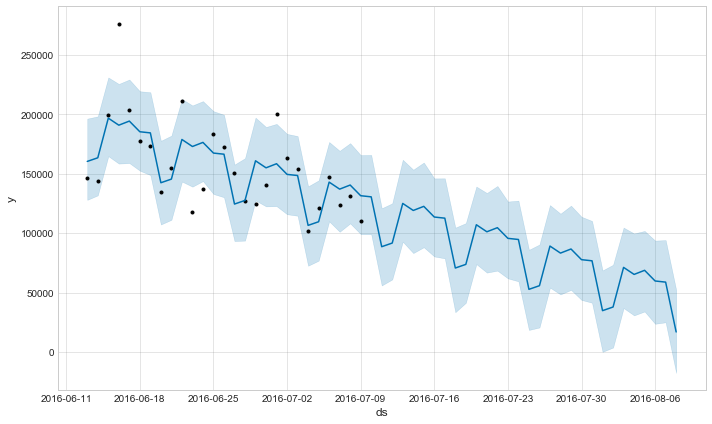

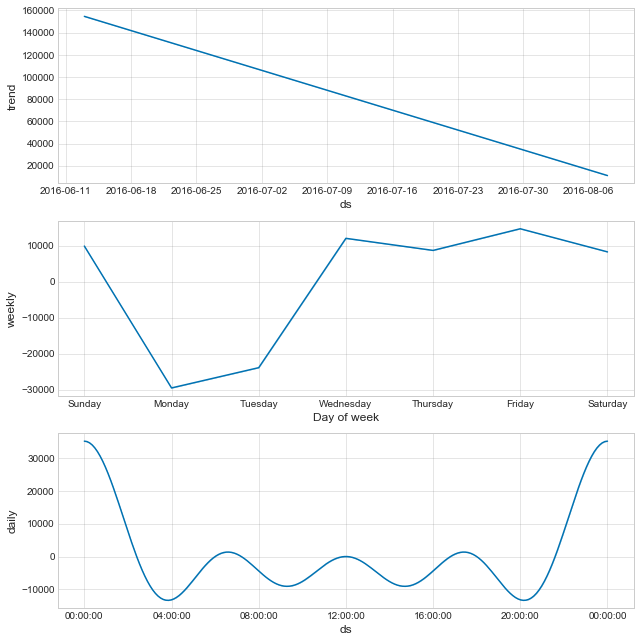

In [131]:
build_platform_prophet(df, 'Mobile')

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


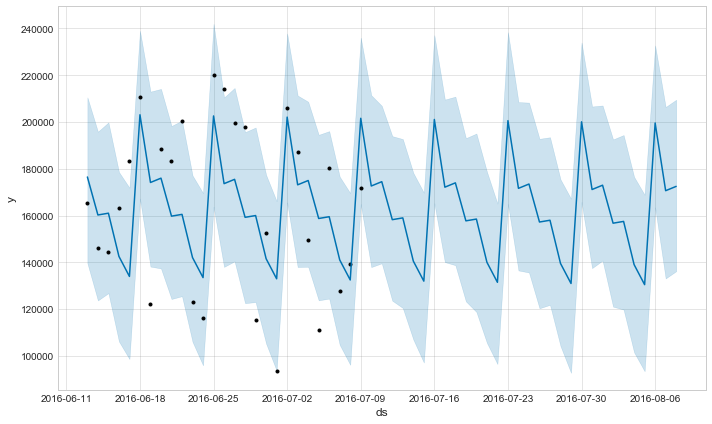

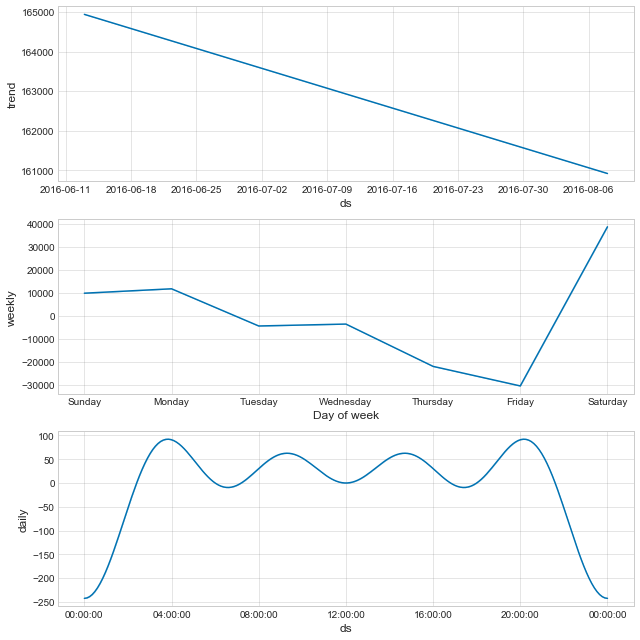

In [132]:
build_platform_prophet(df, 'Tablet')

Tablet data spikes on a Saturday evening, The number of users is quite stable, whereas for Mobile and Computer the number of users is shrinking.